In [36]:
# code to generate the data, run sequentially
# https://colab.research.google.com/drive/1MOmdySo54AnxWmivhmeOXsl4XtaJ1VzF?authuser=2#scrollTo=6443f10e-16a4-4ba6-98ec-0bf2e6f836b1
# https://colab.research.google.com/drive/1jvIr97KQ6SnidX212zX8BBlQ-48zIbp7?authuser=2

import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [37]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA

In [38]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [39]:
data = pd.read_csv("./kaggle/input/synthetic_earthquake.csv")
data.head()

,event_depth,source_lon,source_lat,source_X,source_Y,source_Z,station_distance,first_P_arrival,station_lon,station_lat,...,source_Z_scaled,station_X_scaled,station_Y_scaled,station_Z_scaled,P_arrival_anchor_scaled,P_arrival_shifted_scaled,station_baz_cos,station_baz_sin,features,label
0,1.49,3.44,-86.25,417793.171928,25114.204381,-6.343049e+06,"[24.07, 73.84, 79.28, 60.61, 84.8, 64.68, 6.73...","[316.714379326, 696.19379031, 726.999508839, 6...","[-0.3049327183131503, -134.3555572619309, -118...","[-62.27611165994573, -19.018238986165024, -12....",...,-0.994499,[ 0.46642952 -0.66118305 -0.46477945 -0.145950...,[-0.0024824 -0.67622639 -0.85766538 0.854710...,[-0.88158914 -0.32380275 -0.21924007 -0.496494...,0.351905,[ 0. 0.42164379 0.45587237 0.328379...,[-0.99994468 -0.99894668 -0.99839172 -0.997193...,[ 0.01051836 0.04588603 0.05669197 -0.074872...,[ 0.46642952 -0.0024824 -0.88158914 0. ...,[ 0.06550395 0.00393755 -0.99449872 0.35190487]
1,1.68,3.44,-86.25,417793.159523,25114.203635,-6.343049e+06,"[48.26, 60.78, 62.31, 7.7, 25.64, 1.89, 37.95,...","[522.39676072, 613.384148693, 623.718781866, 1...","[-0.044684452761097226, 32.55732630314448, -30...","[-38.09204305923254, -26.02304705157075, -24.6...",...,-0.994499,[ 0.788025 0.75789143 0.78744714 -0.061446...,[-0.00061457 0.48389682 -0.45505973 0.047250...,[-0.6135788 -0.43607666 -0.41435557 -0.993648...,0.580441,[ 0. 0.1010971 0.11258002 -0.454714...,[-0.9999857 -0.99933019 -0.99916441 -0.946852...,[ 0.00534765 -0.03659471 0.04087142 -0.321667...,[ 7.88024999e-01 -6.14573591e-04 -6.13578801e-...,[ 0.06550395 0.00393755 -0.99449869 0.58044085]
2,1.69,3.44,-86.25,417793.158871,25114.203596,-6.343049e+06,"[22.74, 73.99, 4.7, 69.38, 58.07, 9.84, 17.74,...","[303.340967349, 697.039761426, 71.9476491052, ...","[-8.220336668017483, -106.3259661333287, -124....","[-63.68310895128597, -17.359527487957113, -88....",...,-0.994499,[ 0.43996523 -0.26837783 -0.01307087 -0.910806...,[-0.06355937 -0.91623899 -0.01913982 -0.004515...,[-0.89275937 -0.29645763 -0.99637946 -0.411424...,0.337046,[ 0. 0.4374431 -0.25710369 0.406598...,[-0.99941013 -0.99793461 -0.7735136 -0.999992...,[ 0.03434234 0.06423795 0.6337797 -0.003859...,[ 0.43996523 -0.06355937 -0.89275937 0. ...,[ 0.06550395 0.00393755 -0.99449869 0.33704552]
3,2.54,3.44,-86.25,417793.103378,25114.200260,-6.343048e+06,"[13.33, 49.57, 66.28, 70.95, 42.67, 23.72, 20....","[190.139601573, 532.316822419, 649.608056316, ...","[-99.7997756753601, -100.71594786331187, 106.0...","[-78.09115751129326, -41.5687505961874, -24.67...",...,-0.994499,[-0.03523592 -0.13931842 -0.25178819 0.186407...,[-0.20399898 -0.73619866 0.87369334 -0.929461...,[-0.9750566 -0.6600498 -0.41485272 -0.317292...,0.211266,[ 0. 0.38019691 0.51052051 0.542921...,[-0.96076974 -0.99649817 -0.99755135 -0.997633...,[ 0.27734728 0.08361457 -0.06993788 0.068763...,[-0.03523592 -0.20399898 -0.9750566 0. ...,[ 0.06550394 0.00393754 -0.99449856 0.21126622]
4,3.16,3.44,-86.25,417793.062901,25114.197827,-6.343047e+06,"[74.34, 17.53, 71.96, 86.54, 44.36, 47.9, 58.9...","[698.842328129, 245.336375199, 684.766446187, ...","[-29.829294224003288, 118.907358940014, -168.6...","[-12.538273218936212, -74.480460254115, -21.83...",...,-0.994498,[ 0.84695577 -0.12974431 -0.91064941 0.523381...,[-0.48563137 0.23496009 -0.1821827 -0.851616...,[-0.21567246 -0.96007711 -0.36960312 -0.028563...,0.776491,[ 0. -0.5038955 -0.01563987 0.072813...,[-0.99930072 -0.98042544 -0.99995534 -0.998317...,[ 0.03739076 -0.19689074 0.00945113 0.057980...,[ 0.84695577 -0.48563137 -0.21567246 0. ...,[ 0.06550393 0.00393754 -0.99449846 0.77649148]


In [40]:
data.columns

Index(['event_depth', 'source_lon', 'source_lat', 'source_X', 'source_Y',
       'source_Z', 'station_distance', 'first_P_arrival', 'station_lon',
       'station_lat', 'station_baz', 'station_X', 'station_Y', 'station_Z',
       'P_arrival_anchor', 'P_arrival_shifted', 'source_X_scaled',
       'source_Y_scaled', 'source_Z_scaled', 'station_X_scaled',
       'station_Y_scaled', 'station_Z_scaled', 'P_arrival_anchor_scaled',
       'P_arrival_shifted_scaled', 'station_baz_cos', 'station_baz_sin',
       'features', 'label'],
      dtype='object')

In [41]:
print(data['station_Z_scaled'][0])
print(data['source_Z_scaled'][0])

print("\nfrom (x, y, z, anlge) of 10 stations, predict (x, y, z, T) of the source")

[-0.88158914 -0.32380275 -0.21924007 -0.49649458 -0.03118606 -0.40991164
 -0.98950597 -0.79817732 -0.6736212  -0.50424646]
-0.9944987231534588

from (x, y, z, anlge) of 10 stations, predict (x, y, z, T) of the source


In [42]:
def combine_features(df):
    Xs = np.array(
        [float(i) for i in df.station_X_scaled.strip('[]').split()]
    )
    Ys =  np.array(
        [float(i) for i in df.station_Y_scaled.strip('[]').split()]
    )
    Zs = np.array(
        [float(i) for i in df.station_Z_scaled.strip('[]').split()]
    )
    Ts = np.array(
        [float(i) for i in df.P_arrival_shifted_scaled.strip('[]').split()]
    )
    cos = np.array(
        [float(i) for i in df.station_baz_cos.strip('[]').split()]
    )
    sin = np.array(
        [float(i) for i in df.station_baz_sin.strip('[]').split()]
    )
    features = np.vstack([Xs, Ys, Zs, Ts, cos, sin]).T.flatten()
    
    return features

def combine_labels(df):
    X = df.source_X_scaled
    Y = df.source_Y_scaled
    Z = df.source_Z_scaled
    T = df.P_arrival_anchor_scaled
    label = np.array([X, Y, Z, T])
    return label

In [43]:
data["features"] = data.apply(lambda x:combine_features(x), axis=1)
data["label"] = data.apply(lambda x:combine_labels(x), axis=1)

In [44]:
data[["features", "label"]]

,features,label
0,"[0.46642952, -0.0024824, -0.88158914, 0.0, -0....","[0.0655039507504406, 0.0039375454589072, -0.99..."
1,"[0.788025, -0.00061457, -0.6135788, 0.0, -0.99...","[0.0655039488056401, 0.0039375453420021, -0.99..."
2,"[0.43996523, -0.06355937, -0.89275937, 0.0, -0...","[0.0655039487032822, 0.0039375453358492, -0.99..."
3,"[-0.03523592, -0.20399898, -0.9750566, 0.0, -0...","[0.0655039400028589, 0.0039375448128531, -0.99..."
4,"[0.84695577, -0.48563137, -0.21567246, 0.0, -0...","[0.0655039336566677, 0.0039375444313736, -0.99..."
...,...,...
690,"[0.33382513, 0.04154906, -0.93856148, 0.0, -0....","[0.0654968441423095, 0.00393711826952, -0.9943..."
691,"[-0.54545138, -0.72344768, -0.42179052, 0.0, -...","[0.0654968312452114, 0.0039371174942552, -0.99..."
692,"[-0.05930993, -0.29972806, -0.94898682, 0.0, -...","[0.0654968271508946, 0.0039371172481394, -0.99..."
693,"[0.60031454, 0.79413936, -0.0943669, 0.0, -0.9...","[0.0654968171198183, 0.0039371166451556, -0.99..."


# Feature selection and preprocessing 

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pyproj

# ---- time min max scaler
Time_min_max_scaler = MinMaxScaler(feature_range=(-1,1))
Time_min_max_scaler.fit_transform([[-15*60], [15*60]])

# ---- geocentric scaler (unit in meters)
Geocentric_min_max_scaler = MinMaxScaler(feature_range=(-1,1))
Geocentric_min_max_scaler.fit_transform([[6378.137*1000*-1], [6378.137*1000]])

# ---- geocentric to latlon transformer
transformer_to_latlon = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

In [46]:
scaled_X, scaled_Y, scaled_Z  = -1.00000000e+00,   1.14423775e-17,  -1.11022302e-16

X, Y, Z = Geocentric_min_max_scaler\
          .inverse_transform(np.array([scaled_X, scaled_Y, scaled_Z]).reshape(-1,1))\
          .flatten()

lon, lat, elev = transformer_to_latlon.transform(X, Y, Z)

depth = elev * -1 / 1000 # in km
assert (lon == 180) and (lat < 1e-22) and (elev==0) 
print(lon, lat, elev)

180.0 2.667879307379773e-23 0.0


# Test and Train dataset

In [47]:
# function to create train, test data given stock data and sequence length
# we are predicting future so last portion of our data will be recorded as the test dataset example 50000 datapoints last 10k rakhlo future ka lia
def load_data(df):
    data_raw = df['features'] # convert to numpy array
    labels = df['label']
    
    test_set_size = int(np.round(0.3*data_raw.shape[0])) #30 percent for test
    train_set_size = data_raw.shape[0] - (test_set_size)
    
    x_train = data_raw[:train_set_size]
    y_train = labels[:train_set_size]
    
    x_test = data_raw[train_set_size:]
    y_test = labels[train_set_size:]
    
    x_train = np.stack([i for i in x_train], axis=0)
    y_train = np.stack([i for i in y_train], axis=0)
    x_test = np.stack([i for i in x_test], axis=0)
    y_test = np.stack([i for i in y_test], axis=0)
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length # window size
x_train, y_train, x_test, y_test = load_data(data)
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
time_prediction = True

if time_prediction:
    y_train = y_train[:, -1].reshape(-1, 1)
    y_test = y_test[:, -1].reshape(-1, 1)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

In [50]:
input_size = x_train.shape[1]
lora_size = 1
hidden_size = 256
output_size = 1 if time_prediction else 4
more_state = 2

make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_lora = lambda: ImplicitModelLoRA(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_rnn = lambda: ImplicitRNN(1, hidden_size, hidden_size-2, output_size-2, f=CustomInf, no_D=False)
make_imp_rnn_lora = lambda: ImplicitRNNLoRA(lora_size, 1, hidden_size-2, hidden_size-2, output_size, f=CustomInf, no_D=False)

# Define model

In [ ]:
from typing import Optional

class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)
    
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #.detach() is a PyTorch method that creates a new tensor that does not require gradients. 
        out = self.fc(out[:, -1, :])
        return out

class ImplicitRNN(nn.Module):
    def __init__(self, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.implicit = ImplicitRNNCell(input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)

class ImplicitRNNLoRA(nn.Module):
    def __init__(self, lora_size, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.implicit = ImplicitRNNCellLoRA(lora_size, input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)

In [60]:
# eikonet
class Net(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.ELU()):
            super(Net, self).__init__()
            self.act = activation

            # Input Structure
            self.fc0  = nn.Linear(2*3,32)
            self.fc1  = nn.Linear(32,512)

            # Resnet Block
            self.rn_fc1 = torch.nn.ModuleList([nn.Linear(512, 512) for i in range(nl)])
            self.rn_fc2 = torch.nn.ModuleList([nn.Linear(512, 512) for i in range(nl)])
            self.rn_fc3 = torch.nn.ModuleList([nn.Linear(512, 512) for i in range(nl)])

            # Output structure
            self.fc8  = nn.Linear(512,32)
            self.fc9  = nn.Linear(32,1)

    def forward(self,x):
        x   = self.act(self.fc0(x))
        x   = self.act(self.fc1(x))
        for ii in range(len(self.rn_fc1)):
            x0 = x
            x  = self.act(self.rn_fc1[ii](x))
            x  = self.act(self.rn_fc3[ii](x)+self.rn_fc2[ii](x0))

        x     = self.act(self.fc8(x))
        tau   = abs(self.fc9(x))
        return tau

def EikonalLoss(Yobs,Xp,tau,device):
        dtau  = torch.autograd.grad(outputs=tau, inputs=Xp, grad_outputs=torch.ones(tau.size()).to(device), 
                            only_inputs=True,create_graph=True,retain_graph=True)[0]

        T0    = torch.sqrt(((Xp[:,3]-Xp[:,0])**2 + (Xp[:,4]-Xp[:,1])**2 + (Xp[:,5]-Xp[:,2])**2))  
        T1    = (T0**2)*(dtau[:,3]**2 + dtau[:,4]**2 + dtau[:,5]**2)
        T2    = 2*tau[:,0]*(dtau[:,3]*(Xp[:,3]-Xp[:,0]) + dtau[:,4]*(Xp[:,4]-Xp[:,1]) + dtau[:,5]*(Xp[:,5]-Xp[:,2]))
        T3    = tau[:,0]**2
        S2    = (T1+T2+T3)
        Ypred = torch.sqrt(1/S2)
        diff  = abs(Yobs[:,1]-Ypred)/Yobs[:,1]
        loss  = torch.mean(abs((Yobs[:,1]-Ypred)/Yobs[:,1]))
        return loss, diff
    
class EikoNet(nn.Module):
    def __init__(self, net=Net()):
        super(EikoNet, self).__init__()
        self.net = net
        
    def forward(self, x):
        return self.net(x)

In [51]:
import torch
import torch.nn as nn


# Build model
input_dim = x_train.shape[1]
hidden_dim = 256 #15
num_layers = 2
output_dim = 4


# model, lr = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device), 0.08
model, lr = MLP(input_size, hidden_size, output_size, nn.ReLU).to(device), 0.005
# model, lr = make_imp_relu().to(device), 0.01
# model, lr = make_imp_lora().to(device), 0.01
# model, lr = make_imp_rnn().to(device), 0.004
# model, lr = make_imp_rnn_lora().to(device), 0.008

model.to(device)
print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)

# Example forward pass
x_example = torch.randn(10, input_dim).to(device)  # Example input tensor
output_example = model(x_example)
print(output_example, output_example.shape)


model size: 81152 parameters
tensor([[ 0.1705],
        [ 0.1298],
        [ 0.1260],
        [ 0.0379],
        [-0.1305],
        [-0.0094],
        [ 0.1267],
        [-0.0116],
        [ 0.1214],
        [-0.0979]], grad_fn=<MmBackward0>) torch.Size([10, 1])


# Train Model

In [52]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Forward pass
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.016058366745710373
Epoch  20 MSE:  0.018941251561045647
Epoch  30 MSE:  0.005998253356665373
Epoch  40 MSE:  0.0036840583197772503
Epoch  50 MSE:  0.002580341650173068
Epoch  60 MSE:  0.0014758880715817213
Epoch  70 MSE:  0.000849106116220355
Epoch  80 MSE:  0.0005427679279819131
Epoch  90 MSE:  0.0003925294440705329


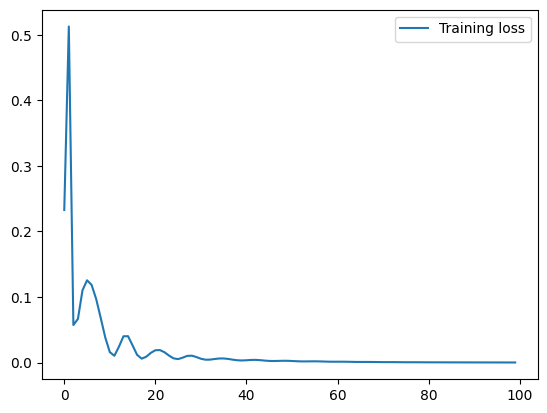

In [53]:
%matplotlib inline
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# Make Predictions


In [54]:
x_test = x_test.to(device)
y_test_pred = model(x_test)
y_test_pred = y_test_pred.cpu().detach().numpy()
y_test= y_test.cpu().detach().numpy()
x_train= x_train.cpu().detach().numpy()
x_test= x_test.cpu().detach().numpy()
y_train= y_train.cpu().detach().numpy()

In [55]:
print(y_test_pred.shape, y_test.shape)
print(*zip(y_test_pred[0:5], y_test[0:5]))

(208, 1) (208, 1)
(array([0.1353241], dtype=float32), array([0.10390008], dtype=float32)) (array([0.81082755], dtype=float32), array([0.7978101], dtype=float32)) (array([0.40837967], dtype=float32), array([0.33726087], dtype=float32)) (array([0.7404274], dtype=float32), array([0.671411], dtype=float32)) (array([0.797531], dtype=float32), array([0.7879863], dtype=float32))


# Accuracy score

In [56]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_pred, y_test)
r2 = r2_score(y_test_pred, y_test)
print(f'r2 (higher better):    {r2:.2f}')
print(f'MAPE (smaller better): {mape:.2f}') 

r2 (higher better):    0.97
MAPE (smaller better): 0.10


# Inverse transform

to see how accurate our results are on line Graph

In [1156]:
# Inverse transform y_test_pred and y_test
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

In [ ]:
len(y_train), len(y_test)

# Results

In [ ]:
import matplotlib.patches as patches

# Assuming y_train, y_test_pred, and y_test are already defined
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot y_train with a different color
plt.plot(range(len(y_train)), y_train, label='TrainData', color='blue')  

# Plot y_test_pred and y_test with different colors
plt.plot(range(len(y_train), len(y_train) + len(y_test_pred)), y_test_pred, label='Predicted', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='ValidationData', color='lightgreen')

# Set the y-axis limits based on the minimum and maximum values of both arrays
plt.ylim(min(y_train.min(), y_test_pred.min(), y_test.min()), max(y_train.max(), y_test_pred.max(), y_test.max()))

# Set the x-axis limits
plt.xlim(0, len(y_train) + len(y_test))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel(fea_name)

# Display the legend
plt.legend()

# Add a square around the y_test_pred
ax = plt.gca()
rect = patches.Rectangle((len(y_train), min(y_test_pred.min(), y_test.min())), len(y_test_pred), 
                         max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min()), 
                         linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Add text label to the rectangle
plt.text(len(y_train) + len(y_test_pred) / 2, min(y_test_pred.min(), y_test.min()) - 0.05 * (max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min())), 
         'Predictions | Test', horizontalalignment='center', verticalalignment='top', fontsize=12, color='black')

# Show the plot
plt.grid(True)  # Add a grid if desired
plt.show()


In [1159]:
# torch.save(model, 'netflix_implicitRNN_20.pt')